In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import textwrap

def drawGraph(data2Draw,current,trues,pos):
 
    text = str("Now we delete:"+textwrap.fill(str(current), 40)+"\n\n\n\nTrues: "+textwrap.fill(str(trues), 40))
    #print (text)
    #return
    width = 10
    height = 15
    plt.figure(figsize=(width, height))
    dx = nx.DiGraph()
    dx = nx.nx.complete_multipartite_graph(1,2,3,4)
    dx.add_nodes_from(data2Draw['members'])
    dx.add_edges_from(data2Draw['edges'])
    if pos == 0:
        pos = nx.random_layout(dx,2,4)
    nx.draw_networkx_labels(dx, pos, data2Draw['labels'], font_size=16)
    nx.draw_networkx_nodes(dx, pos, nodelist=data2Draw['members'], node_color='r',node_size=700)
    nx.draw_networkx_nodes(
        dx, pos, nodelist=data2Draw['name'], node_color='y', node_shape='s', node_size=1300, linewidths=10)
    nx.draw_networkx_edges(
        dx, pos, edgelist=data2Draw['edges'], edge_color='b', arrows=True)
    
    

    red_patch = mpatches.Patch(color='red', label='Members')
    yellow_patch = mpatches.Patch(color='y', label='Lamdas')
    
    
    plt.legend(handles=[red_patch,yellow_patch], loc=1)
    plt.annotate(text,xy=(1.05,0.5),xycoords='axes fraction', fontsize=14)
    plt.show()
    return pos


In [25]:
def mergeDict(dictA, dictB):
    for m in dictB.keys():
        if m not in dictA.keys():
            dictA[m] = dictB[m]
        dictA[m] = (dictA[m])
    return dictA

def mergeData(data1, data2):
    allData = {}
    allData['labels'] = mergeDict(data1['labels'], data2['labels'])
    allData['edges'] = data1['edges'] | data2['edges']
    allData['members'] = data1['members'] | data2['members']
    allData['name'] = list(set().union(data1['name'],[data2['name']]))

    return allData

def getData(sentence):
    leftMembers = sentence['leftMembers']
    name = sentence['name']
    rightMembers = sentence['rightMembers']
    labels = {}
    edges = []
    for m in leftMembers:
        labels[m] = m
        edges.append((m, name))
    for m in rightMembers:
        labels[m] = m
        edges.append((name, m))
    labels[name] = name
    if len (rightMembers) == 0:
        leftMembers = []
    return ({'labels':  (labels), 'edges': set(edges),
             'members': set(leftMembers) | set(rightMembers), 'name': name})

In [26]:
import pydot
def drawGraph2(data2Draw):
    graph = pydot.Dot(graph_type='graph')
    pyNodes = {}
    for n in set(data2Draw['members']):
        pyNodes[n] = pydot.Node(n, fillcolor='r')
    for n in set(data2Draw['names']):
        pyNodes[n] = pydot.Node(n, fillcolor="b", shape='box')
    for edge in set(data2Draw['edges']):
        graph.add_edge(pydot.Edge(edge[0], edge[1], label='a', color='r'))
    graph.write_png('ojj.png')

In [27]:
def findIndependetMembers(data,val):
    if val == 0:
        independentMember = {key: 0 for key in set(data['name'])}
    else:
        independentMember = {key: 0 for key in set(data['members'])}

    for k in data['edges']:
        if k[1] in independentMember:
            independentMember[k[1]] += 1
    return [l for l in independentMember.keys() if independentMember[l]==0]


def updateGraph(dataToProcess, trues, pos):
    dataToProcess, lamdasDeleted = removeLambda(dataToProcess, trues, pos)
    dataToProcess, membersDeleted = removeMember(dataToProcess, trues, pos)
    
    return dataToProcess, membersDeleted

def removeLambda(dataToProcess, trues, pos):
    toDelete = findIndependetMembers(dataToProcess,0)
    for e in [l for l in data['edges'] if l[0] in toDelete]:
        dataToProcess['edges'].remove(e)
    for e in toDelete:
        del dataToProcess['labels'][e]
        dataToProcess['name'].remove(e)
        
    drawGraph(dataToProcess,toDelete,trues, pos)        
    return dataToProcess, toDelete

def removeMember(dataToProcess,trues,pos):
    toDelete = findIndependetMembers(dataToProcess,1)
    for e in [l for l in dataToProcess['edges'] if l[0] in toDelete]:
        dataToProcess['edges'].remove(e)
    for e in toDelete:
        del dataToProcess['labels'][e]
        dataToProcess['members'].remove(e)
    drawGraph(dataToProcess,toDelete,trues , pos)    
    return dataToProcess, toDelete

def updateSentencesAndGetTrues(sentences, membersToDelete):
    retValue = []
    for m in membersToDelete:
        for s in sentences:
            if [m] == s['rightMembers']:
                retValue.append(m)
                s['edges'] = []
                continue;
            if m in s['leftMembers']:
                del s
                continue
            if m in s['rightMembers']:
                s['rightMembers'].remove(m)
    return set(retValue), sentences
                
def convertJson2Theory(sentences):
    [print (l['name']+':'+str(l['leftMembers'])+'->'+str(l['rightMembers'])) for l in sentences]          

In [28]:
import random, string

def generateRandomSentences(num,lenght,members):
    retValue = []
    for i in range(num):
        val = {}
        lengthR = int (random_num(lenght))
        lengthL = int (random_num(lenght))
        val = {}
        val['name']= 'L' +str(i)
        val['leftMembers']=[]
        for j in range(lengthL):
            val['leftMembers'].append(randomword(members))
        val['rightMembers']=[]
        for j in range(lengthR):
            val['rightMembers'].append(randomword(members))
        retValue.append(val)
    return retValue
        
def random_num(length):
    return random.randint(1, length) 


def randomword(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))

In [29]:
def readFile(filename):
    f = open(filename,'r').read().replace(':[',';').replace(']->[',';').replace(']','').replace("'",'')
    allS = f.split('\n')
    listSentences = []
    for i in allS:
        t = i.split(';')
        listSentences.append({'name':t[0],'leftMembers':t[1].split(','),'rightMembers':t[2].split(',')})
    return listSentences
def insert_newlines(string, every=64):
    return '\n'.join(string[i:i+every] for i in range(0, len(string), every))

In [30]:
originalSentences = [
    {'leftMembers': [], 'name': ('L1'), 'rightMembers': ['a', 'b']},
    {'leftMembers': ['b'], 'name': ('L2'), 'rightMembers': ['a']},
    {'leftMembers': [], 'name': ('L3'), 'rightMembers': ['a', 'c']},
    {'leftMembers': ['a'], 'name': ('L4'), 'rightMembers': ['d', 'e', 'f']},
    {'leftMembers': ['e'], 'name': ('L5'), 'rightMembers': ['f']},
    {'leftMembers': ['f'], 'name': ('L6'), 'rightMembers': ['e']},
]

In [36]:
originalSentences = generateRandomSentences(60,3,2)

In [32]:
originalSentences = readFile('example 1.txt')

In [37]:
convertJson2Theory(originalSentences)


L0:['st']->['zi', 'el']
L1:['pk', 'pb', 'nm']->['rr', 'fs', 'ut']
L2:['yo']->['re', 'yn']
L3:['xh', 'hh']->['rt']
L4:['ee', 'ss', 'gh']->['fg', 'dp', 'eg']
L5:['oq', 'vw', 'yc']->['cb']
L6:['vg', 'lj']->['ly', 'ut', 'wm']
L7:['zu', 'ua', 'yk']->['ha', 'bz', 'jb']
L8:['cc', 'rs', 'nj']->['px', 're', 'ar']
L9:['eh']->['sv']
L10:['ws', 'az']->['mm', 'yv', 'ye']
L11:['jk', 'sl']->['nf', 'lb']
L12:['fz', 'qc']->['wr']
L13:['fc']->['pk', 'kq']
L14:['wa', 'rr', 'vo']->['in', 'hj']
L15:['td', 'tk', 'jy']->['re', 'cm']
L16:['nz', 'tf', 'ev']->['cz', 'tq', 'ts']
L17:['jp', 'uo', 'xm']->['qp', 'dh']
L18:['nb', 'nh']->['jn', 'gj', 'ao']
L19:['iy']->['cm', 'ix']
L20:['iz']->['wa', 'tb']
L21:['zz']->['ra', 'qj']
L22:['oh']->['mx']
L23:['zv', 'td']->['ow']
L24:['tw', 'te']->['pe', 'ym']
L25:['mb', 'xr']->['rs', 'xr', 'uy']
L26:['lp']->['cs', 'bz', 'ao']
L27:['cm']->['ot', 'jm', 'nq']
L28:['ka']->['nz', 'eq']
L29:['nr']->['un', 'kz']
L30:['cm', 'td', 'gr']->['cc', 'il', 'bt']
L31:['uz', 'mk']->['ww']


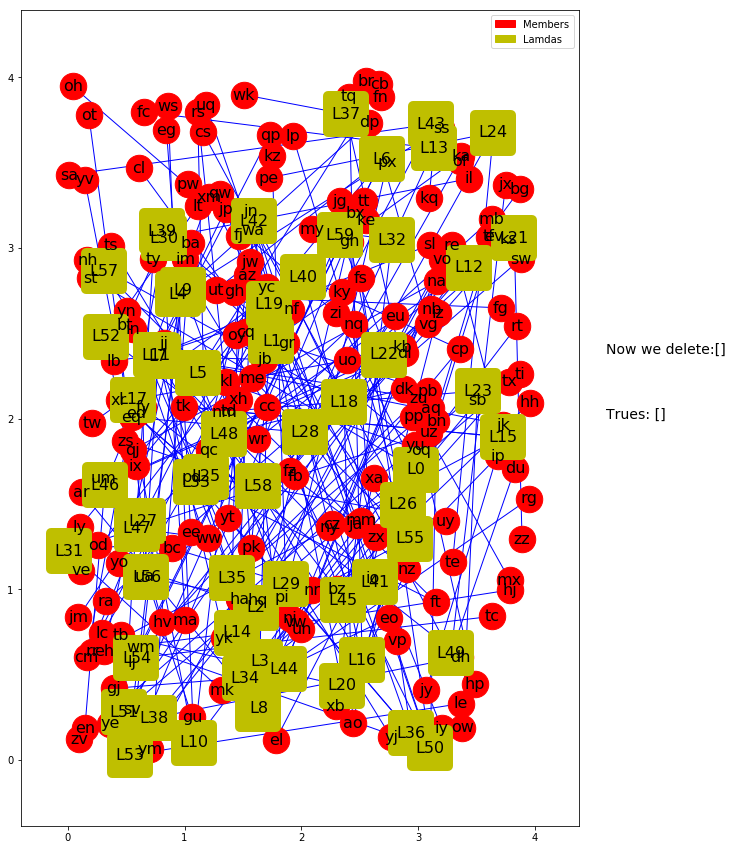

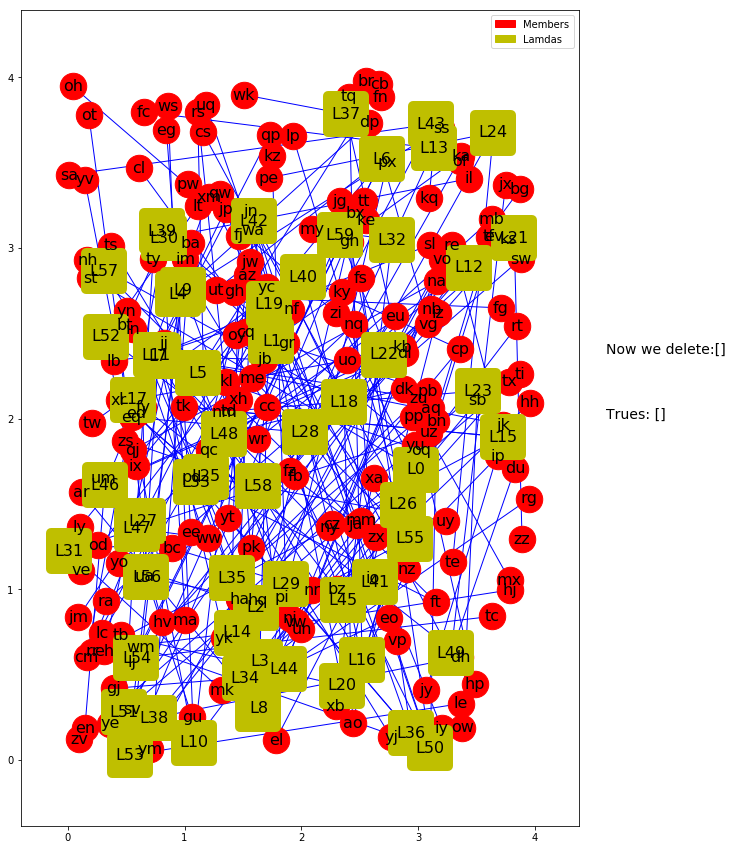

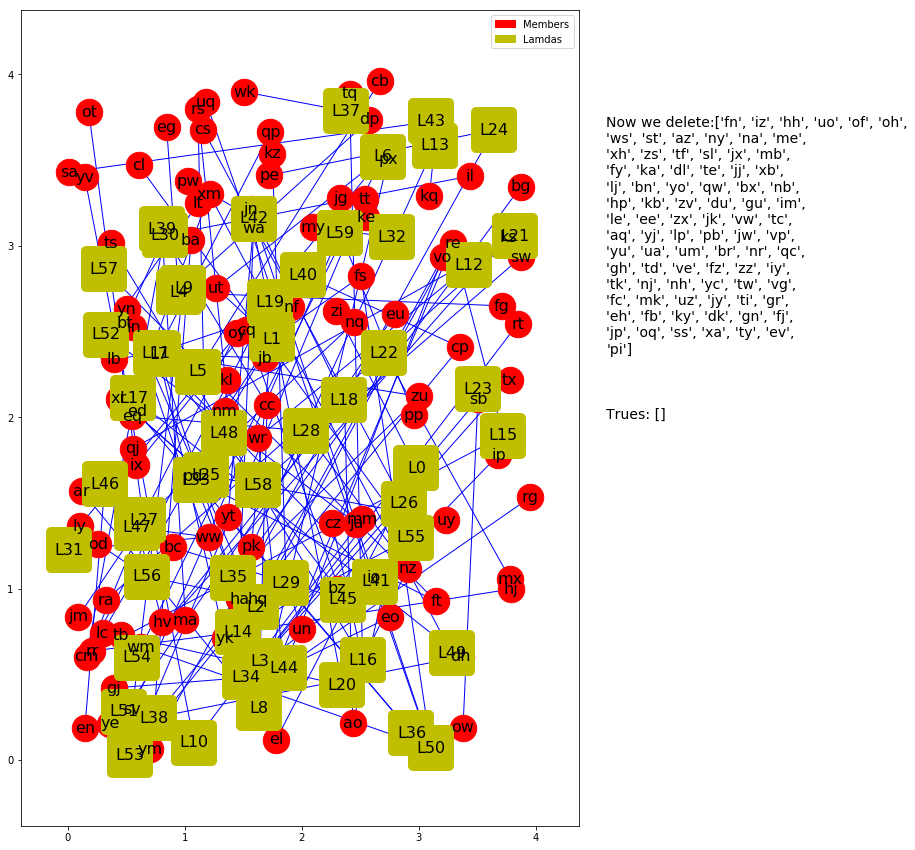

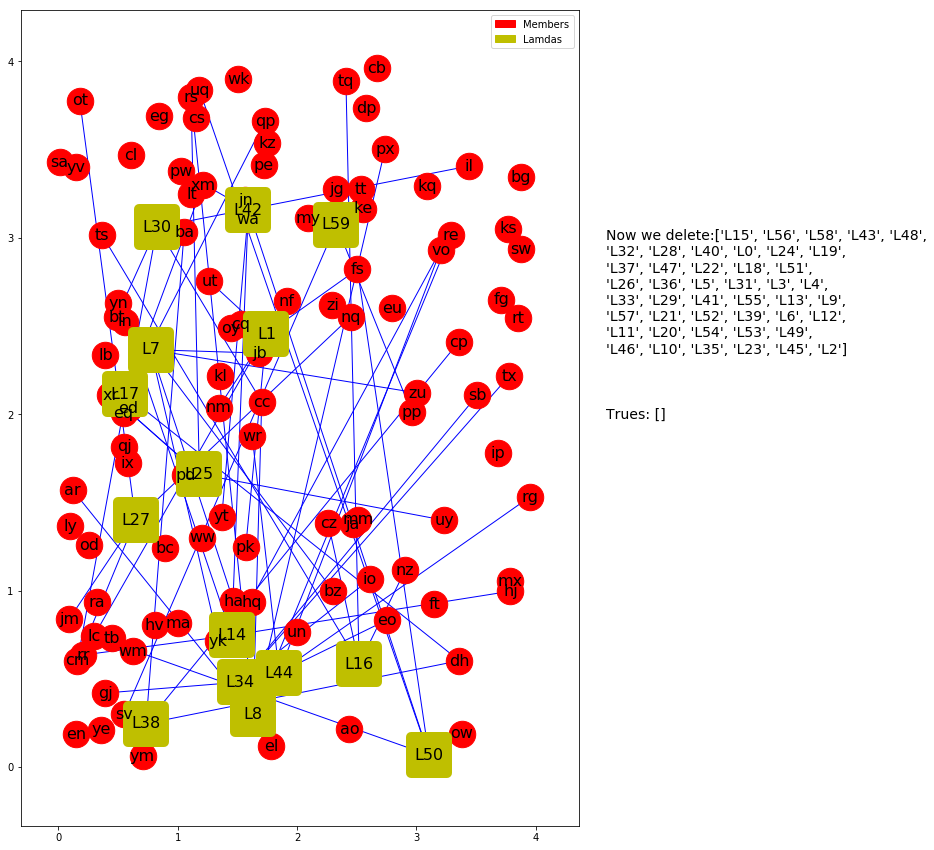

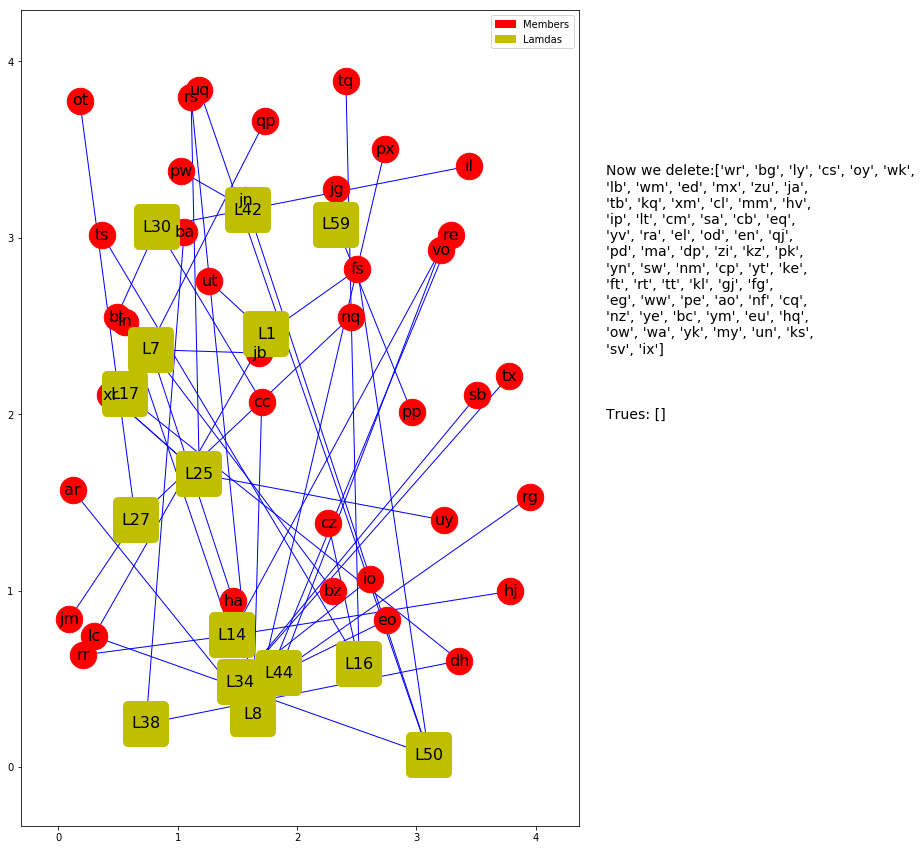

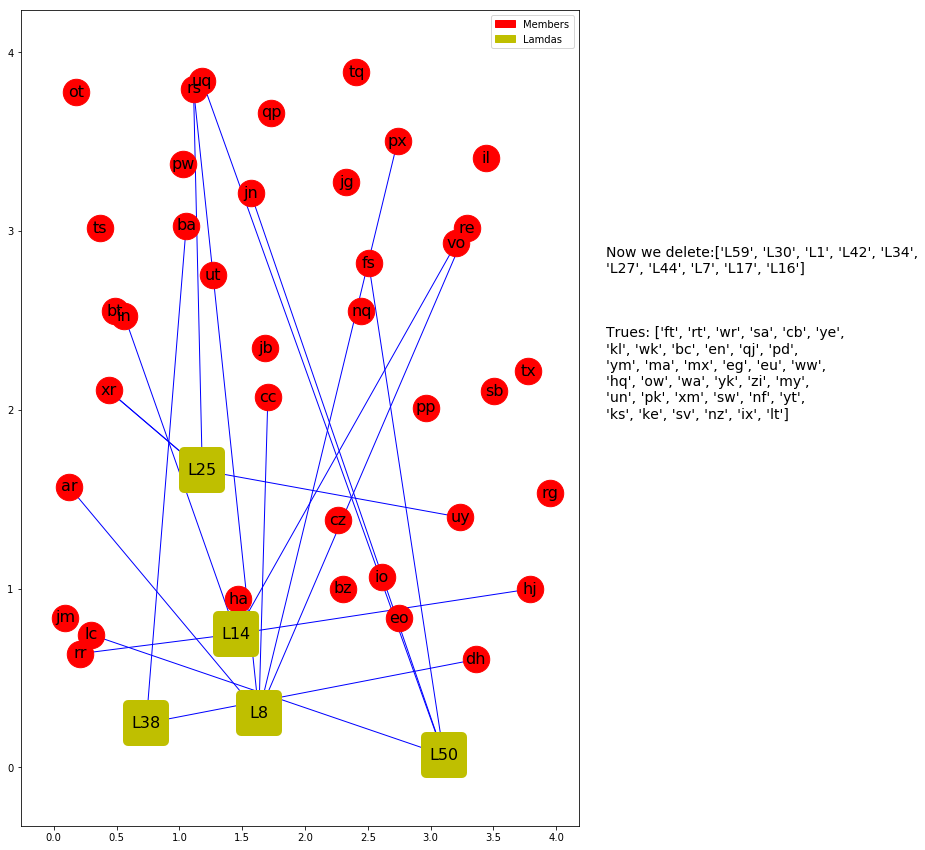

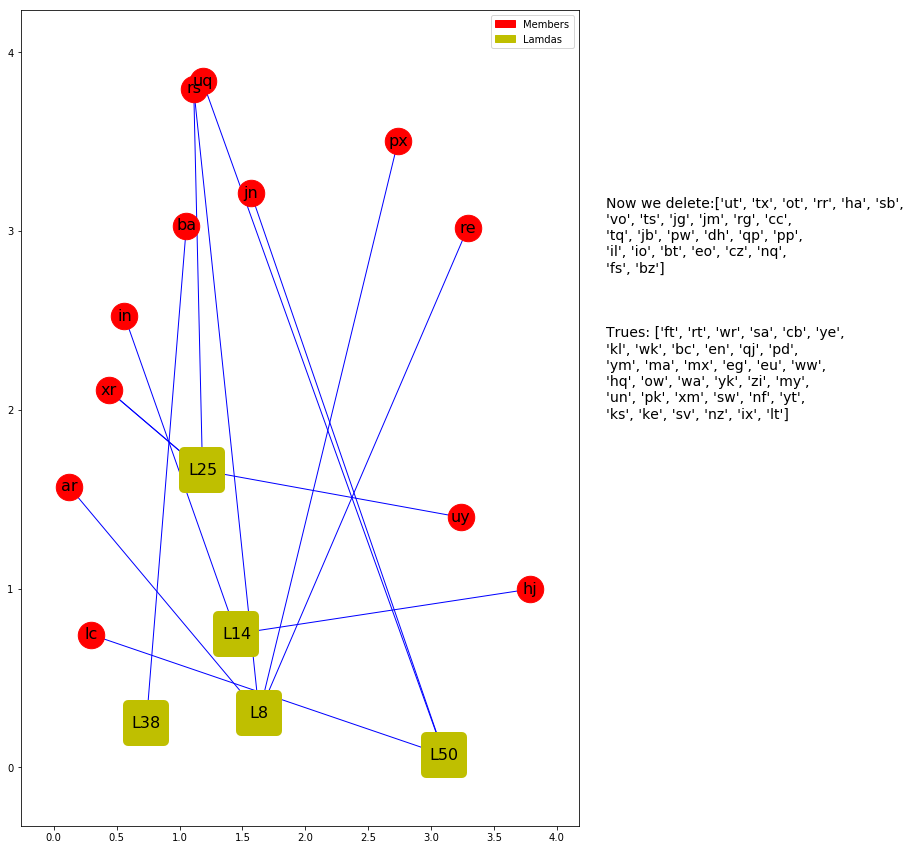

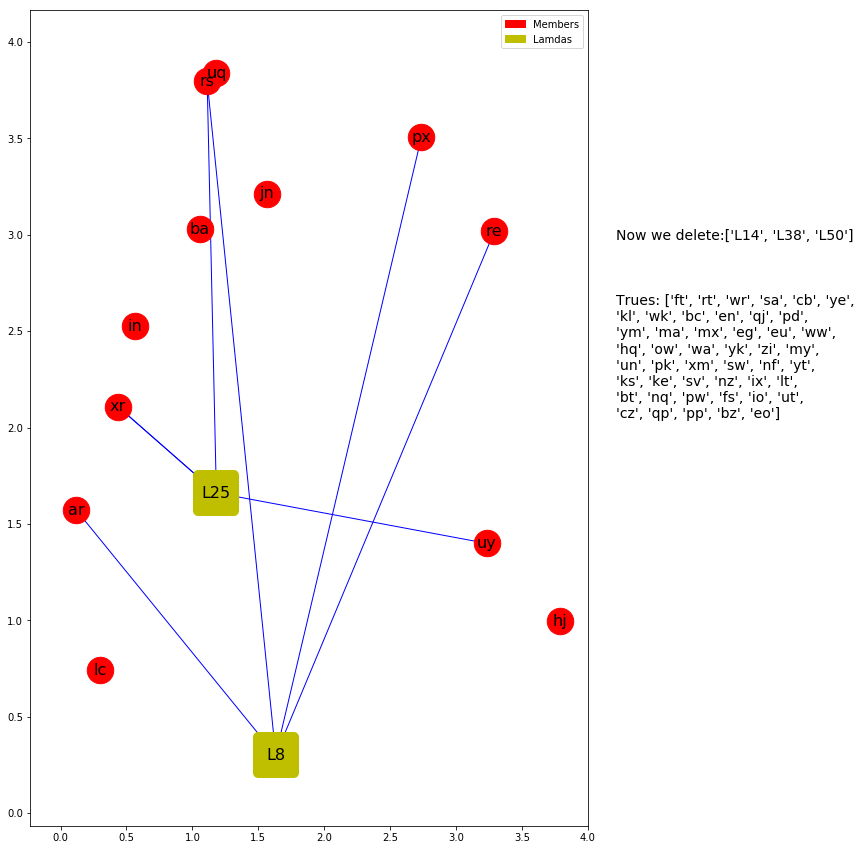

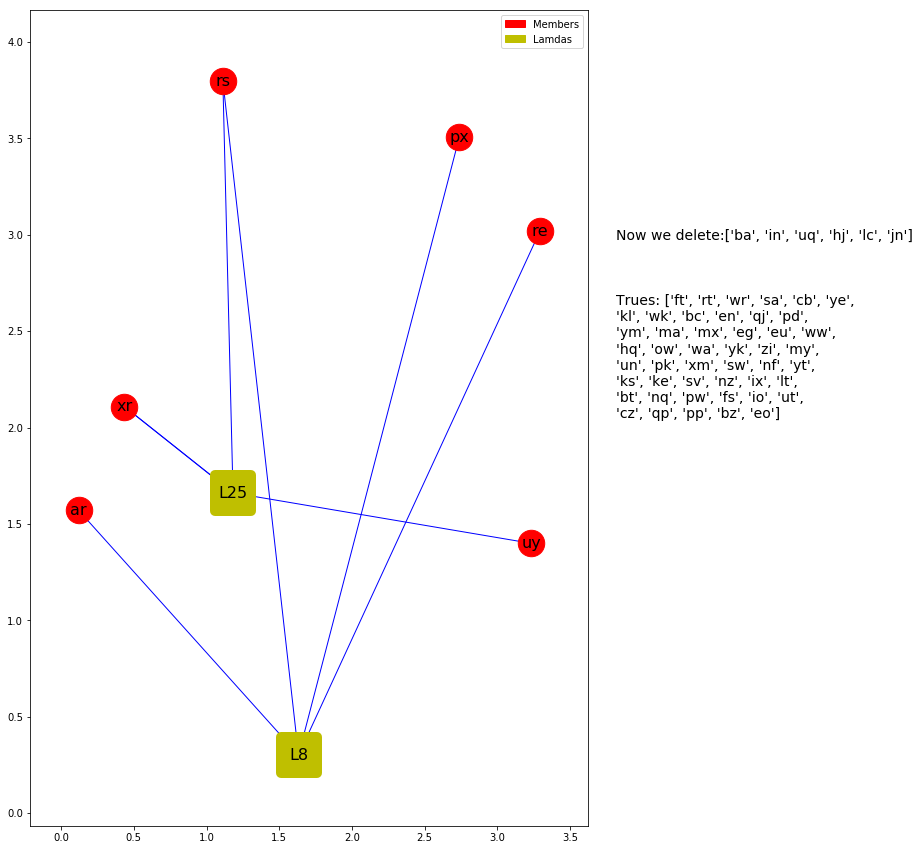

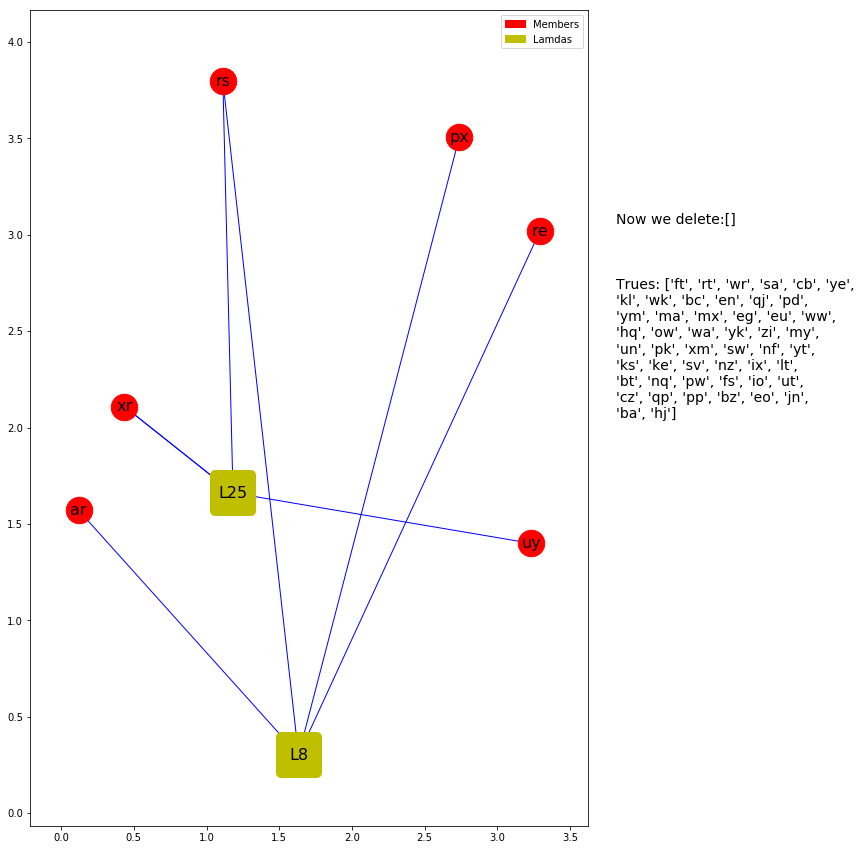

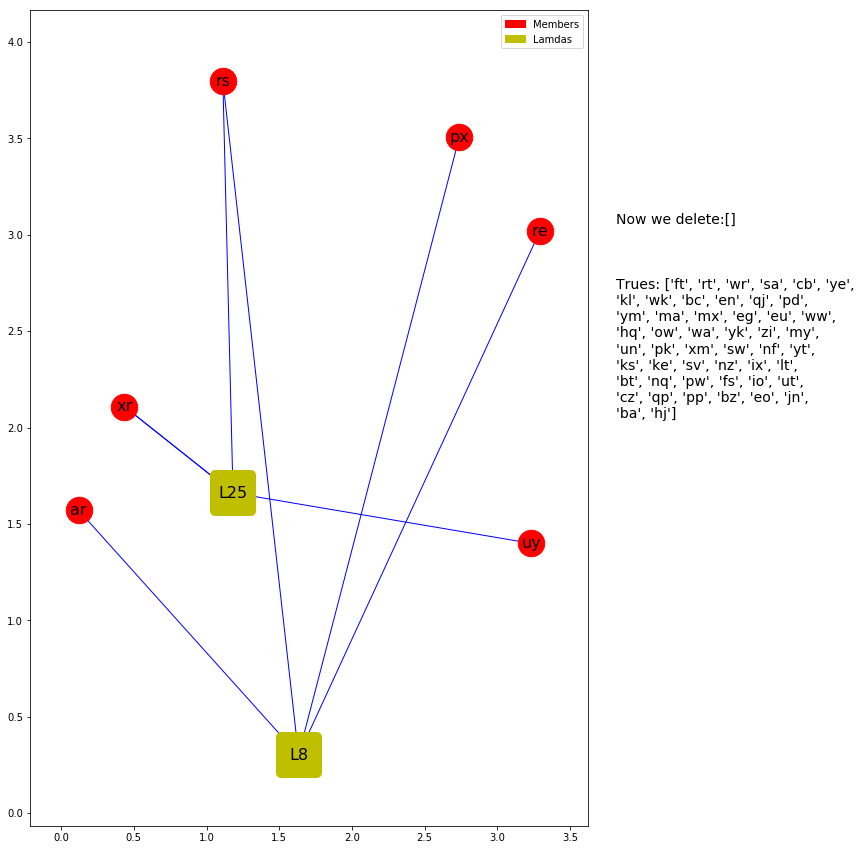

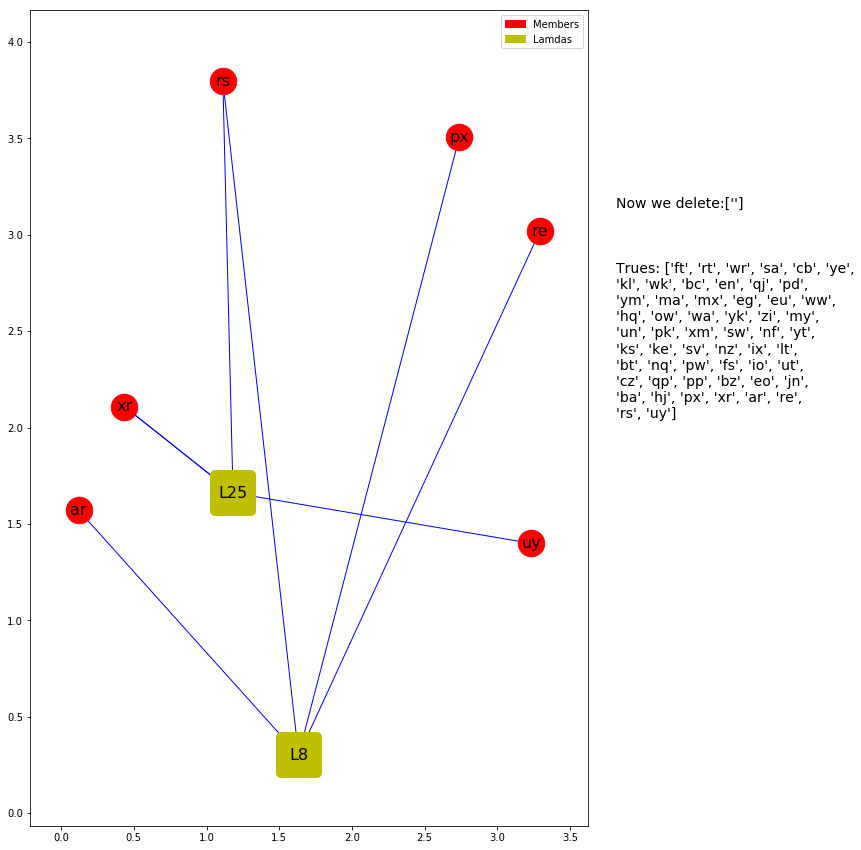

--------Finished--------


In [38]:



trues = []
deletedMembers = []
data = {'name':[],'edges':set(),'members':set(),'labels':{}}
for oS in originalSentences:
    data = mergeData(data, getData(oS))
sentences = originalSentences
pos = drawGraph(data,deletedMembers,trues, 0)
#drawGraph2(data)
lastState = []
curState = [len(data['name']),len(data['edges']),len(data['members'])]

while lastState != curState:
    lastState = curState
    data,membersDeleted = updateGraph(data,trues, pos)
    curT, sentences = updateSentencesAndGetTrues(sentences, membersDeleted)
    curState = [len(data['name']),len(data['edges']),len(data['members'])]
    if len(curT)>0:
        trues+=curT
trues+=data['members']
drawGraph(data,[''],trues,pos)
print ('--------Finished--------')



